# Estimating a model with a known number of events

This section will show you how to estimate a single HMP model with a given number of event. We will generate data as in the demo on the github main page but we'll make it harder to find for the HMP algortihm by reducing the amplitude of the generating sources.

In [21]:
#Development only
import sys
sys.path.insert(0, "/home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/src")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
## Importing the package
import hsmm_mvpy as hmp

## Imports and code specific to the simulation (see tutorial 3 and 4 for real data)
import os
import numpy as np
from scipy.stats import gamma
from hsmm_mvpy import simulations
import matplotlib.pyplot as plt 
import seaborn as sns

cpus = 10 # For multiprocessing, usually a good idea to use multiple CPus as long as you have enough RAM

## Parameters for the simulations
frequency, amplitude = 10., .3e-6 #Frequency of the transition event and its amplitude in Volt
shape = 2#shape of the gamma distribution

#Storing electrode position, specific to the simulations
positions = simulations.simulation_positions()#Electrode position
sfreq = simulations.simulation_sfreq()#sampling freqency of the simulated data
resample_freq = 100#Resampling at 100Hz to make processing faster and less demanding
all_source_names = simulations.available_sources()#all brain sources you can play with
n_trials = 50 #Number of trials to simulate

# Randomly specify the transition events
n_events = 8
name_sources = np.random.choice(all_source_names,n_events+1, replace=False)#randomly pick source without replacement
times = np.random.uniform(25,300,n_events+1)/shape#randomly pick average times in millisecond between the events

sources = []
for source in range(len(name_sources)):
    sources.append([name_sources[source], frequency, amplitude, \
                      gamma(shape, scale=times[source])])

file = 'dataset_tutorial2' #Name of the file to save

#Simulating and recover information on electrode location and true time onset of the simulated events
files = simulations.simulate(sources, n_trials, cpus,file, overwrite=True, location=25)
generating_events = np.load(files[1])
number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
random_source_times = np.reshape(np.diff(generating_events[:,0], prepend=0),(n_trials,number_of_sources+1))[:,1:]/(sfreq/resample_freq)#By-trial generated event times

#Reading the necessary info to read the EEG data
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}
resp_id = {'response':resp_trigger}
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

# Reading the data
eeg_dat = hmp.utils.read_mne_data(files[0], event_id, resp_id, sfreq=resample_freq, events_provided=events, verbose=False)
hmp_dat = hmp.utils.transform_data(eeg_dat, apply_standard=False, n_comp=number_of_sources-1)

Reading labels from parcellation...
   read 34 labels from /home/gweindel/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 34 labels from /home/gweindel/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Simulating ./dataset_tutorial2_raw.fif


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

HMP uses classes to instantiate fit of hmp models. Therefore before estimating a model one needs to declare an instance of the hmp class by specifying the data, the sampling frequency of the data as well as several parmeters such as the event width (in milliseconds) and how many CPU to use.

In [2]:
init = hmp.models.hmp(hmp_dat, sfreq=eeg_dat.sfreq, event_width=50, cpus=cpus)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one hmp model with a specified number of transition events

## Direct estimation
We can simply call the ```fit_single``` method from the hmp class to estimate a given number of events. The hmp algorithm will then look for 4 events. Now the expectation maximization algorithm to fit the model is in this case sensitive to the starting points given to the stage duration. By default, the ```fit_single``` method uses a starting point where all events are equally distributed between 0 and the mean RT.

Estimating 8 events model with 1 starting point(s)
Parameters estimated for 8 events model


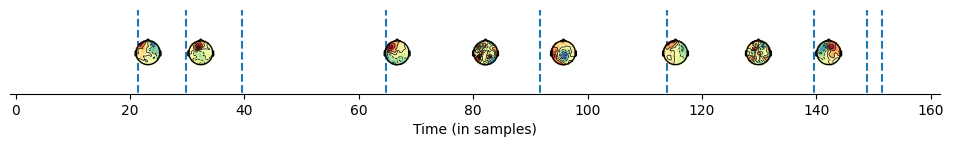

In [3]:
#Fitting
selected = init.fit_single(number_of_sources-1)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Now launching a single model without additional starting points is not a good idea as often the default starting values of the expectation maximization algorithm will end up in a local minima. We need to use more starting points and we developed several methods for that
 

## Random method


A better idea is to run a single model with several starting points as can be declared in the ```single_fit()``` function, hereby an example with 100 random starting points:

Estimating 8 events model with 1000 starting point(s)
Parameters estimated for 8 events model


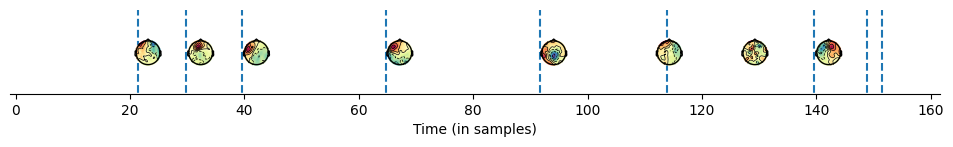

In [4]:
# Fitting
selected = init.fit_single(number_of_sources-1, method='random', starting_points=1000)#function to fit an instance of a 4 events model
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

But, by definition, the starting points are random so inducing a lot of redundancy and also taking the risk that some points in the parameter space remain unexplored.

## Grid search 
In an effort to circumvent these limitations we designed a function called ```grid_search``` which basically decomposes the mean RT into a grid with points. After having defined the grid, the function then generates all possible combination of 
        _n_ event placements within this grid. It is faster than using random points (both should converge with enough starting points) but depending on the mean RT and the number 
        of events to look for, the number of combination can be really large. For this reason we also need to specify a maximum number of starting point. The ```grid_search```function will then scale the grid according to the maximum starting points number requested. Note that this method works nicely for :
- 1 event models
- very high number of short events 

Estimating 8 events model with 500 starting point(s)
Initial number of possibilities is 5257211409450. Given a number of max iteration = 500: fitting 165 models based on all possibilities from grid search with a spacing of 11 samples and 13 points and durations of [11. 22. 33. 44.]
Parameters estimated for 8 events model


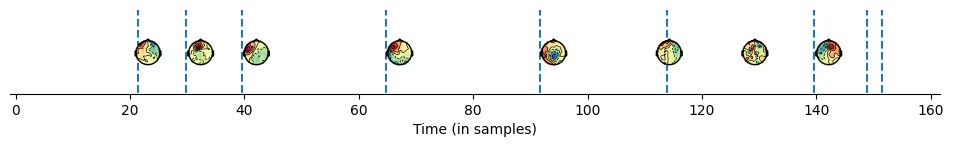

In [5]:
#Fitting
selected = init.fit_single(number_of_sources-1, method='grid', starting_points=500)#function to fit an instance of a 4 events model
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Works also but see how we needed to reduce the number of combinations by specifying ```starting_points=100```. The output shows us that the algorithm used a spacing of 80 samples between tested location and this could be suboptimal, even more if we had a longer mean RT. Ideally we want a method that looks for likelihood of a event at any sample.

## Backward estimation

Now both solutions might not be enough for example if you are trying to fit a medium number of events, generating too many possibilties for grid search (which then decreases precision in the grid) or requesting too many random starting points. Therefore, an even better solution than random points is to estimate the maximal number of possible events.

The idea is that genuine events will necessarily be found at the expected locations in the maximal number of event model and because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remains even if there location would have been hard to find with a single fit and default starting values.
To do that we will use the ```backward_estimation()``` function. This function first estimate the max_event solution (defined based on the event width and the minimum reaction time) then estimate max_event - 1 solution by iteratively removing one of the event and pick the one with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution. 

In [6]:
%%time 
bests = init.backward_estimation()

Estimating all solutions for maximal number of events (18) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 17 number of events
Estimating all solutions for 16 number of events
Estimating all solutions for 15 number of events
Estimating all solutions for 14 number of events
Estimating all solutions for 13 number of events
Estimating all solutions for 12 number of events
Estimating all solutions for 11 number of events
Estimating all solutions for 10 number of events
Estimating all solutions for 9 number of events
Estimating all solutions for 8 number of events
Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
CPU times: user 3.82 s, sys: 2.45 s, total: 6.27 s
Wal

Here we plot the resulting solutions going from the maximal possible number of events that fit into the minimum RT given a minimum duration of 25ms in this example 

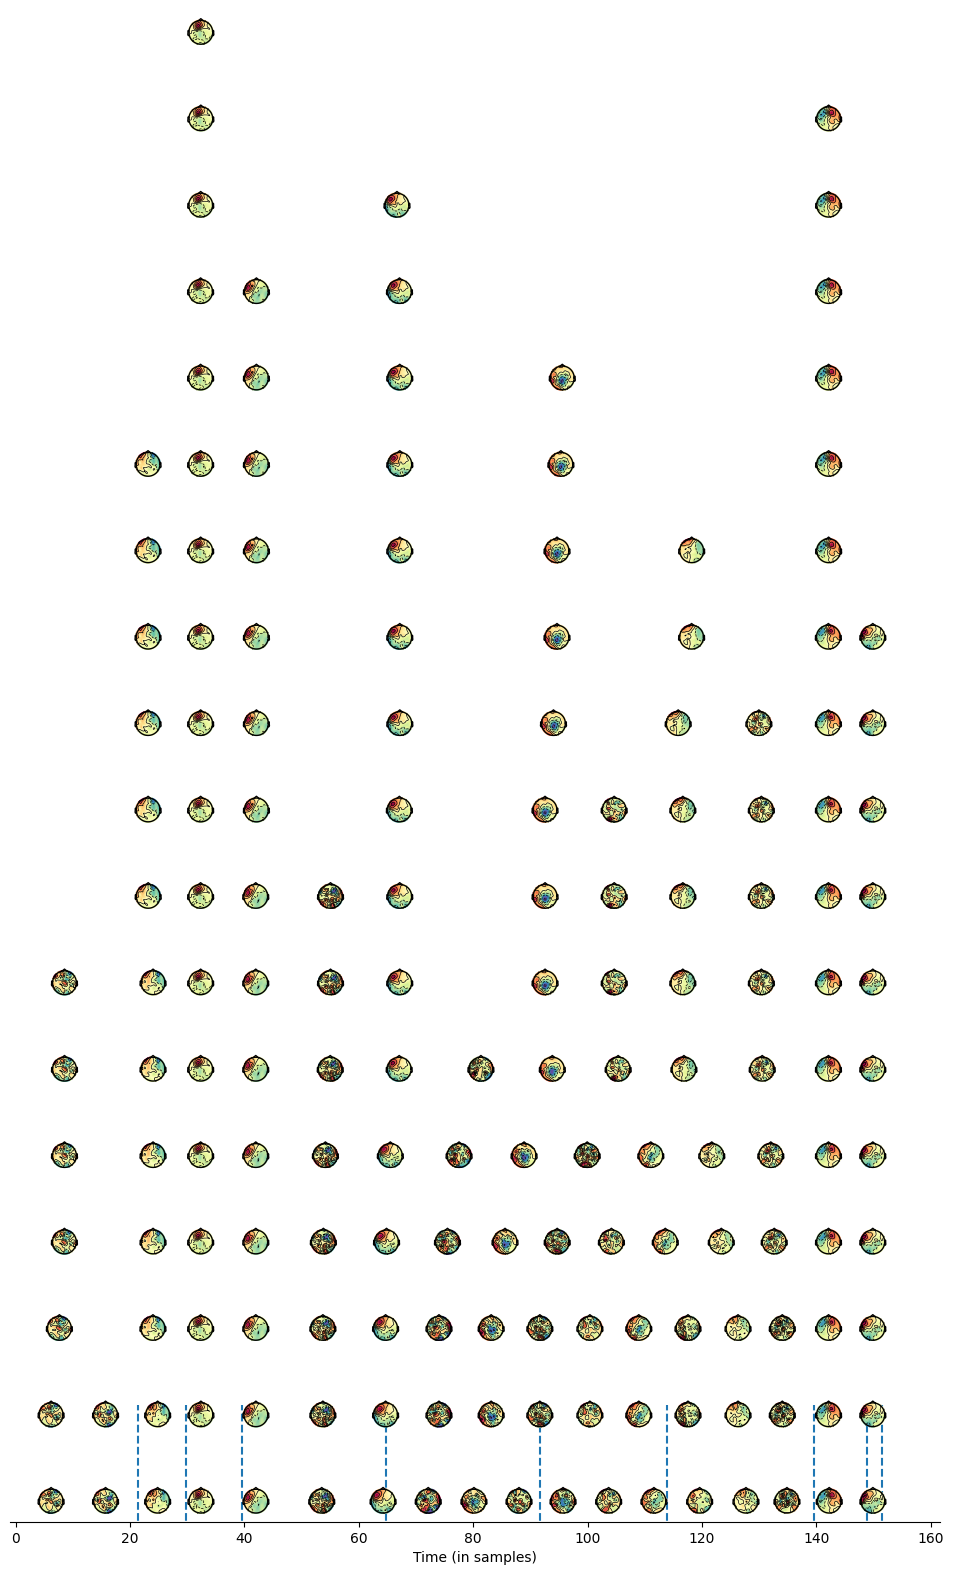

In [7]:
hmp.visu.plot_topo_timecourse(eeg_dat, bests, positions, init, sensors=False, ydim='n_events',
                    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

And from these solutions we can then select the number of events we wanted to estimate:

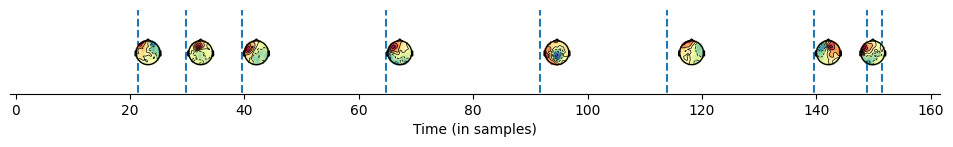

In [8]:
selected = bests.sel(n_events=number_of_sources-1)
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Now the downside is that we are still unsure about whether we included all possible starting point in the mix and this method can turn bad with 1) long RTs and therefore a lot of events to fit and long computation times and 2) if there is a big difference between the minimum RT (determining the maximum number of events) and the mean RT (all possible locations of these events).

## Cumulative event fit

Instead of fitting an _n_ event model, this method fits a 2 event model using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as an estimated event exceeds the previous one by a given ```threshold```, the funtions fits a _n+1_ event model and uses the next samples in the RT for the following event.

In [9]:
estimates = init.fit(threshold=1, verbose=True)

  0%|          | 0/151 [00:00<?, ?it/s]

Transition event 2 found around sample 30
Transition event 3 found around sample 41
Transition event 4 found around sample 65
Transition event 5 found around sample 94
Transition event 6 found around sample 140
Transition event 7 found around sample 144
Estimating 7 events model
Parameters estimated for 7 events model


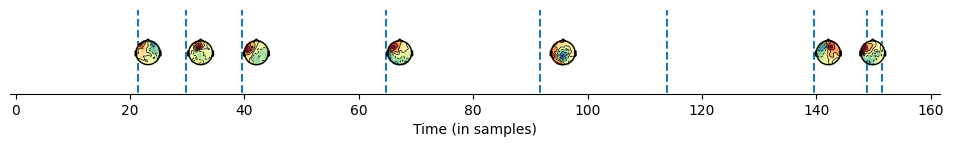

In [10]:
hmp.visu.plot_topo_timecourse(eeg_dat, estimates, positions, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

One downside of this method is the use of a thresholding. A too high threshold will yield a 1 event/2 stages model or return a subset of the actual events. It remains to be found a method that can accomodate any dataset but for now the only solution is to play around with several thresholds:

In [11]:
estimates = init.fit(threshold=.1, verbose=False)

  0%|          | 0/151 [00:00<?, ?it/s]

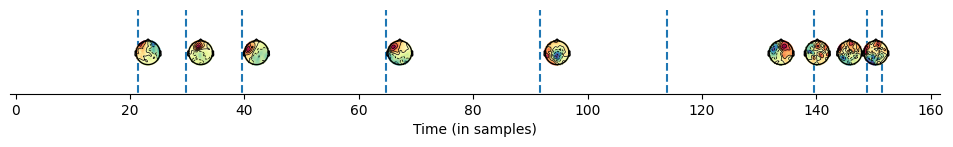

In [12]:
hmp.visu.plot_topo_timecourse(eeg_dat, estimates, positions, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Decreasing the threshold induced some confabulated events but the true events are recovered. We can combine this method and the backward estimation by using the 'lenient threshold' version and feed it to the backward estimation method:

In [13]:
bests = init.backward_estimation(max_fit=estimates, min_events=3)#.We limit at 3 just for readabilty

Estimating all solutions for 8 number of events
Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events


Here we plot the resulting solutions going from the maximal possible number of events that fit into the minimum RT given a minimum duration of 25ms in this example

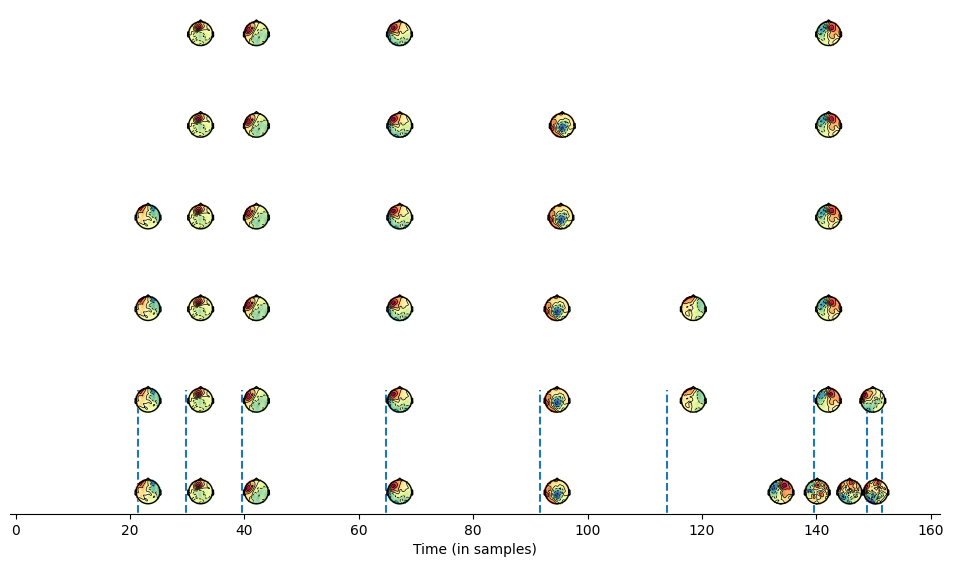

In [14]:
hmp.visu.plot_topo_timecourse(eeg_dat, bests, positions, init, sensors=False, ydim='n_events',
                    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

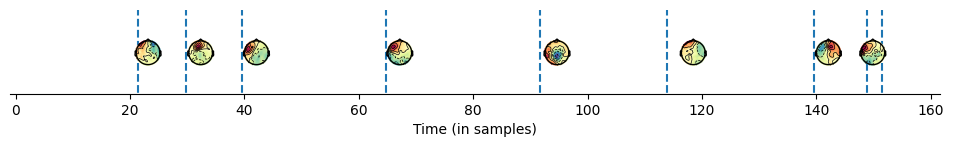

In [15]:
selected = bests.sel(n_events=number_of_sources-1)
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

# Data saving

Once finished we can save all the fitted models using the dedicated command

In [16]:
hmp.utils.save_fit(estimates, 'selected.nc')

selected.nc saved


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


And load the same way

In [17]:
estimates = hmp.utils.load_fit('selected.nc')

Or even only save the estimated event probabilities 

In [18]:
hmp.utils.save_eventprobs(estimates.eventprobs, 'selected_eventprobs.nc')

Saved at selected_eventprobs.nc
